In [1]:
import pandas as pd
%matplotlib inline
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np
from sklearn.manifold import TSNE

from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import confusion_matrix, classification_report

import torch_geometric.utils as utils
import torch
import torch.nn.functional as F
from torch_geometric.utils import subgraph
from torch_geometric.nn import GraphConv
from torch_geometric.nn import GATConv
from torch_geometric.nn import GCNConv
from torch_geometric.nn import SAGEConv

In [2]:
df1 = pd.read_excel("radicalism/PIRUS_V4.xlsx")
df2 = pd.read_excel("radicalism/SoNAR_Edges.xlsx")
df3 = pd.read_excel("radicalism/SoNAR_Nodes.xlsx")

In [3]:
df1

,Subject_ID,Loc_Plot_State1,Loc_Plot_City1,Loc_Plot_State2,Loc_Plot_City2,Year_Exposure,Plot_Target1,Plot_Target2,Plot_Target3,Attack_Preparation,...,Trauma,Other_Ideologies,Angry_US,Group_Grievance,Component_ID,Component_Density,Lone_Offender,Degree_Centrality,Betweenness_Centrality,Closeness_Centrality
0,1000,Illinois,Chicago,Florida,Broward County,2002,14,NaN,NaN,1,...,0,0,0,0,6,0.190000,0,5,0.112319,0.444444
1,1001,California,San Francisco,NaN,NaN,2001,-88,NaN,NaN,-88,...,-99,0,1,-99,1525,-88.000000,1,0,0.000000,0.000000
2,1002,California,Santa Ana,NaN,NaN,1997,-99,NaN,NaN,-99,...,-99,0,1,1,471,1.000000,0,1,0.000000,1.000000
3,1005,New York,New York,NaN,NaN,1993,1,NaN,NaN,2,...,0,0,1,2,9,0.573099,0,9,0.179739,0.666667
4,1006,New York,New York,NaN,NaN,1993,1,NaN,NaN,2,...,-99,0,1,-99,9,0.573099,0,9,0.179739,0.666667
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
3198,12147,District of Columbia,Washington,NaN,NaN,2021,2,3.0,NaN,1,...,0,0,1,0,1535,-88.000000,1,0,0.000000,0.000000
3199,12148,District of Columbia,Washington,NaN,NaN,2021,2,3.0,NaN,1,...,0,0,1,0,38,0.527778,0,3,0.428571,0.615385
3200,12149,Oregon,Salem,NaN,NaN,2021,14,NaN,NaN,-99,...,0,0,0,0,1,0.005436,0,4,0.000000,0.098882
3201,12151,Oregon,Salem,NaN,NaN,2021,14,NaN,NaN,-99,...,0,0,0,0,1,0.005436,0,4,0.000000,0.098882


In [4]:
df1.isnull().sum()

Subject_ID                   0
Loc_Plot_State1              0
Loc_Plot_City1               0
Loc_Plot_State2           2939
Loc_Plot_City2            2965
                          ... 
Component_Density            0
Lone_Offender                0
Degree_Centrality            0
Betweenness_Centrality       0
Closeness_Centrality         0
Length: 130, dtype: int64

In [5]:
df1.dropna(axis=1, how='any', inplace=True)

In [6]:
# Make sure that we have no duplicate nodes
max(df1["Subject_ID"].value_counts())

1

In [7]:
state_dict = {state: i for i, state in enumerate(df1['Loc_Plot_State1'].unique())}
df1['Loc_Plot_State1'] = df1['Loc_Plot_State1'].map(state_dict)

In [8]:
city_dict = {}
for state in df1['Loc_Plot_State1'].unique():
    cities = df1[df1['Loc_Plot_State1'] == state]['Loc_Plot_City1'].unique()
    city_dict[state] = {city: i for i, city in enumerate(cities)}
df1['Loc_Plot_City1'] = df1.apply(lambda x: city_dict[x['Loc_Plot_State1']][x['Loc_Plot_City1']], axis=1)


In [9]:
df1['Loc_Plot_State1'] = df1['Loc_Plot_State1'].astype(int)
df1['Loc_Plot_City1'] = df1['Loc_Plot_City1'].astype(int)

In [10]:
df1 = df1.merge(df3, on='Subject_ID')

In [11]:
labels = df1[["Ideology"]]

In [12]:
print(labels.Ideology.unique())

['Islamist' 'White Supremacist/Nativist'
 'Anti-Government/Sovereign Citizen' 'Environmental/Animal Rights' 'Other'
 'Conspiracy Theory' 'Anarchist/Anti-Capitalist' 'Anti-Abortion'
 'Black Nationalist/Separatist']


In [13]:
label_dict = {state: i for i, state in enumerate(labels['Ideology'].unique())}
labels['Ideology'] = labels['Ideology'].map(label_dict)
labels['Ideology'] = labels['Ideology'].astype(int)

C:\Users\Razaq\AppData\Local\Temp\ipykernel_8444\58358649.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  labels['Ideology'] = labels['Ideology'].map(label_dict)
C:\Users\Razaq\AppData\Local\Temp\ipykernel_8444\58358649.py:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  labels['Ideology'] = labels['Ideology'].astype(int)


In [14]:
print(labels)
print(labels.Ideology.unique())

      Ideology
0            0
1            0
2            0
3            0
4            0
...        ...
3198         1
3199         1
3200         1
3201         1
3202         1

[3203 rows x 1 columns]
[0 1 2 3 4 5 6 7 8]


In [15]:
df1 = df1.drop(['Ideology', 'Decade',	'In_PIRUS'], axis=1)

In [16]:
string_columns = df1.select_dtypes(include=['object']).columns

# convert string columns to numeric encoding
for col in string_columns:
    df1[col] = pd.Categorical(df1[col]).codes

C:\Users\Razaq\AppData\Roaming\Python\Python310\site-packages\pandas\core\algorithms.py:798: FutureWarning: In a future version, the Index constructor will not infer numeric dtypes when passed object-dtype sequences (matching Series behavior)
  uniques = Index(uniques)


In [17]:
df2 = df2.dropna()

In [18]:
scaler = StandardScaler()
x = scaler.fit_transform(df1.iloc[:, 2:].values)

x = torch.from_numpy(x).float()
y = torch.from_numpy(labels['Ideology'].values).float()

x_train, x_test, y_train, y_test = train_test_split(x, y, test_size=0.2, random_state=42)


df2['Subject_A'] = pd.factorize(df2['Subject_A'])[0]
df2['Subject_B'] = pd.factorize(df2['Subject_B'])[0]

edges = np.array(df2[['Subject_A', 'Subject_B']])

num_nodes = len(np.unique(edges))
edge_index = torch.from_numpy(edges.T).long()
edge_index -= edge_index.min()  # Shift indices to start from zero

edge_index_train, edge_index_test = train_test_split(edge_index.t(), test_size=0.2, random_state=42)

# Transpose edge_index_train and edge_index_test
edge_index_train = edge_index_train.t()
edge_index_test = edge_index_test.t()


num_nodes_train = x_train.size(0)
num_edges_train = edge_index_train.size(1)
edge_index_train = torch.tensor(edge_index_train, dtype=torch.long)

# Ensure that the indices are within the valid range
edge_index_train = edge_index_train.remainder(num_nodes_train)

# Create edge_index_test
num_nodes_test = x_test.size(0)
num_edges_test = edge_index_test.size(1)
edge_index_test = torch.tensor(edge_index_test, dtype=torch.long)

# Ensure that the indices are within the valid range
edge_index_test = edge_index_test.remainder(num_nodes_test)



C:\Users\Razaq\AppData\Local\Temp\ipykernel_8444\2046016760.py:28: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  edge_index_train = torch.tensor(edge_index_train, dtype=torch.long)
C:\Users\Razaq\AppData\Local\Temp\ipykernel_8444\2046016760.py:36: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  edge_index_test = torch.tensor(edge_index_test, dtype=torch.long)


In [19]:
scaler = StandardScaler()
x = scaler.fit_transform(df1.iloc[:, 2:].values)

x = torch.from_numpy(x).float()
y = torch.from_numpy(labels['Ideology'].values).float()

x_train, x_test, y_train, y_test = train_test_split(x, y, test_size=0.2, random_state=42)

df2['Subject_A'] = pd.factorize(df2['Subject_A'])[0]
df2['Subject_B'] = pd.factorize(df2['Subject_B'])[0]

edges = np.array(df2[['Subject_A', 'Subject_B']])

num_nodes = len(np.unique(edges))
edge_index = torch.from_numpy(edges.T).long()
edge_index -= edge_index.min()  # Shift indices to start from zero

# Normalize edge_index
edge_index = edge_index / num_nodes

# Split into train and test sets
edge_index_train, edge_index_test = train_test_split(edge_index.t(), test_size=0.2, random_state=42)

# Transpose edge_index_train and edge_index_test
edge_index_train = edge_index_train.t()
edge_index_test = edge_index_test.t()

# Ensure that the indices are within the valid range
num_nodes_train = x_train.size(0)
num_edges_train = edge_index_train.size(1)
edge_index_train = torch.tensor(edge_index_train, dtype=torch.long)

# Ensure that the indices are within the valid range
edge_index_train = edge_index_train.remainder(num_nodes_train)

# Create edge_index_test
num_nodes_test = x_test.size(0)
num_edges_test = edge_index_test.size(1)
edge_index_test = torch.tensor(edge_index_test, dtype=torch.long)

# Ensure that the indices are within the valid range
edge_index_test = edge_index_test.remainder(num_nodes_test)

C:\Users\Razaq\AppData\Local\Temp\ipykernel_8444\740033225.py:31: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  edge_index_train = torch.tensor(edge_index_train, dtype=torch.long)
C:\Users\Razaq\AppData\Local\Temp\ipykernel_8444\740033225.py:39: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  edge_index_test = torch.tensor(edge_index_test, dtype=torch.long)


In [20]:
import torch

unique_labels, label_counts = torch.unique(y_train, return_counts=True)
print(unique_labels)
print(label_counts)

print('x_train: ', x_train.shape)
print('x_test: ', x_test.shape)
print('y_train: ', y_train.shape)
print('y_test: ', y_test.shape)
print('edge_index_train: ', edge_index_train.shape)
print('edge_index_test: ', edge_index_test.shape)

tensor([0., 1., 2., 3., 4., 5., 6., 7., 8.])
tensor([476, 778, 448, 143, 213,  99, 201, 112,  92])
x_train:  torch.Size([2562, 90])
x_test:  torch.Size([641, 90])
y_train:  torch.Size([2562])
y_test:  torch.Size([641])
edge_index_train:  torch.Size([2, 11065])
edge_index_test:  torch.Size([2, 2767])


In [21]:
label_list = list(label_dict.keys())

def visualize(h, color, labels):
    z = TSNE(n_components=2).fit_transform(h.detach().cpu().numpy())

    plt.figure(figsize=(10,10))
    plt.xticks([])
    plt.yticks([])

    scatter = plt.scatter(z[:, 0], z[:, 1], s=70, c=color, cmap="Set2", label=labels)
    plt.legend(handles=scatter.legend_elements()[0], labels=labels, bbox_to_anchor=(1.02, 1), loc='upper left', borderaxespad=0)
    plt.show()

In [22]:
class GCN(torch.nn.Module):
    def __init__(self):
        super(GCN, self).__init__()

        self.conv1 = GraphConv(num_features, hidden_dim)
        self.convs = torch.nn.ModuleList()
        for i in range(num_layers - 1):
            self.convs.append(GraphConv(hidden_dim, hidden_dim))
        self.fc = torch.nn.Linear(hidden_dim, num_classes)
        self.dropout = torch.nn.Dropout(dropout_rate)

    def forward(self, x, edge_index):
       
        x = F.relu(self.conv1(x, edge_index))

        for conv in self.convs:       
            x = F.relu(conv(x, edge_index))
            x = self.dropout(x)
        x = self.fc(x)
        return F.log_softmax(x, dim=1)


class G2R(torch.nn.Module):
    def __init__(self):
        super(G2R, self).__init__()

        self.conv1 = GCNConv(num_features, hidden_dim)
        self.convs = torch.nn.ModuleList()
        for i in range(num_layers - 1):
            self.convs.append(GCNConv(hidden_dim, hidden_dim))
        self.fc = torch.nn.Linear(hidden_dim, num_classes)
        self.dropout = torch.nn.Dropout(dropout_rate)

    def forward(self, x, edge_index):
       
        x = F.relu(self.conv1(x, edge_index))

        for conv in self.convs:       
            x = F.relu(conv(x, edge_index))
            x = self.dropout(x)
        x = self.fc(x)
        return F.log_softmax(x, dim=1)


class FisherGCN(torch.nn.Module):
    def __init__(self):
        super(FisherGCN, self).__init__()

        self.conv1 = GCNConv(num_features, hidden_dim)
        self.convs = torch.nn.ModuleList()
        for i in range(num_layers - 1):
            self.convs.append(GCNConv(hidden_dim, hidden_dim))
        self.fc = torch.nn.Linear(hidden_dim, num_classes)
        self.dropout = torch.nn.Dropout(dropout_rate)

    def forward(self, x, edge_index):
       
        x = F.relu(self.conv1(x, edge_index))

        for conv in self.convs:       
            x = F.relu(conv(x, edge_index))
            x = self.dropout(x)
        x = self.fc(x)
        return F.log_softmax(x, dim=1)
        

class GraphSAGE(torch.nn.Module):
    def __init__(self):
        super(GraphSAGE, self).__init__()

        self.conv1 = SAGEConv(num_features, hidden_dim)
        self.convs = torch.nn.ModuleList()
        for i in range(num_layers - 1):
            self.convs.append(SAGEConv(hidden_dim, hidden_dim))
        self.fc = torch.nn.Linear(hidden_dim, num_classes)

    def forward(self, x, edge_index):
        x = F.dropout(x, p=dropout_rate, training=self.training)
        x = F.relu(self.conv1(x, edge_index))
        for conv in self.convs:
            x = F.dropout(x, p=dropout_rate, training=self.training)
            x = F.relu(conv(x, edge_index))
        x = self.fc(x)
        return F.log_softmax(x, dim=1)


class GAT(torch.nn.Module):
    def __init__(self):
        super(GAT, self).__init__()

        self.conv1 = GATConv(num_features, hidden_dim, heads=8, dropout=dropout_rate)
        self.convs = torch.nn.ModuleList()
        for i in range(num_layers - 1):
            self.convs.append(GATConv(hidden_dim * 8, hidden_dim, heads=8, dropout=dropout_rate))
        self.fc = torch.nn.Linear(hidden_dim * 8, num_classes)

    def forward(self, x, edge_index):
        x = F.dropout(x, p=dropout_rate, training=self.training)
        x = F.elu(self.conv1(x, edge_index))
        for conv in self.convs:
            x = F.dropout(x, p=dropout_rate, training=self.training)
            x = F.elu(conv(x, edge_index))
        x = torch.cat([x[:, i::8 * hidden_dim] for i in range(8 * hidden_dim)], dim=1)  # Concatenate attention heads
        x = self.fc(x)
        return F.log_softmax(x, dim=1)



In [23]:
num_features = x_train.size(1) 
hidden_dim = 1024#16-1024
num_classes = 9
num_layers = 3 #2-4
dropout_rate = 0.5
num_epochs = 1000

*********************Running model is GCN(
  (conv1): GraphConv(90, 1024)
  (convs): ModuleList(
    (0-1): 2 x GraphConv(1024, 1024)
  )
  (fc): Linear(in_features=1024, out_features=9, bias=True)
  (dropout): Dropout(p=0.5, inplace=False)
)************************
Epoch 0: Train Loss: 33040354.0000, Test Loss: 5990299.0000, Test Accuracy: 0.3058
Epoch 50: Train Loss: 0.1784, Test Loss: 33506104.0000, Test Accuracy: 0.7863
Epoch 100: Train Loss: 0.0063, Test Loss: 33112442.0000, Test Accuracy: 0.7925
Epoch 150: Train Loss: 0.0014, Test Loss: 31849786.0000, Test Accuracy: 0.7878
Epoch 200: Train Loss: 0.0010, Test Loss: 32241802.0000, Test Accuracy: 0.7956
Epoch 250: Train Loss: 0.0007, Test Loss: 32163796.0000, Test Accuracy: 0.7910
Epoch 300: Train Loss: 0.0007, Test Loss: 32217274.0000, Test Accuracy: 0.7785
Epoch 350: Train Loss: 0.0006, Test Loss: 32264918.0000, Test Accuracy: 0.7972
Epoch 400: Train Loss: 0.0003, Test Loss: 32427084.0000, Test Accuracy: 0.7894
Epoch 450: Train Lo

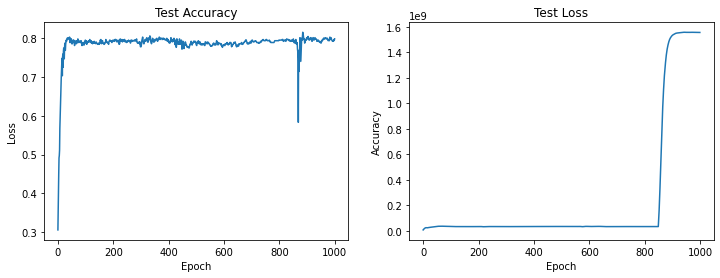

Accuracy: 0.7988
Confusion Matrix:
Classification Report:
                                   precision    recall  f1-score   support

                         Islamist       0.98      0.99      0.99       104
       White Supremacist/Nativist       0.81      0.83      0.82       196
Anti-Government/Sovereign Citizen       0.65      0.65      0.65       110
      Environmental/Animal Rights       0.95      0.90      0.93        42
                            Other       0.75      0.73      0.74        49
                Conspiracy Theory       0.64      0.59      0.62        27
        Anarchist/Anti-Capitalist       0.76      0.79      0.77        52
                    Anti-Abortion       0.79      0.72      0.75        32
     Black Nationalist/Separatist       0.67      0.69      0.68        29

                         accuracy                           0.80       641
                        macro avg       0.78      0.77      0.77       641
                     weighted avg       

C:\Users\Razaq\AppData\Local\Programs\Python\Python310\lib\site-packages\sklearn\manifold\_t_sne.py:795: FutureWarning: The default initialization in TSNE will change from 'random' to 'pca' in 1.2.
  warnings.warn(
C:\Users\Razaq\AppData\Local\Programs\Python\Python310\lib\site-packages\sklearn\manifold\_t_sne.py:805: FutureWarning: The default learning rate in TSNE will change from 200.0 to 'auto' in 1.2.
  warnings.warn(


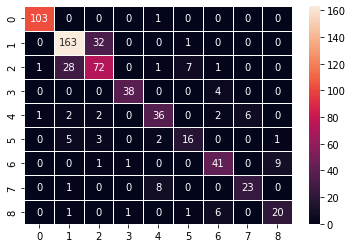

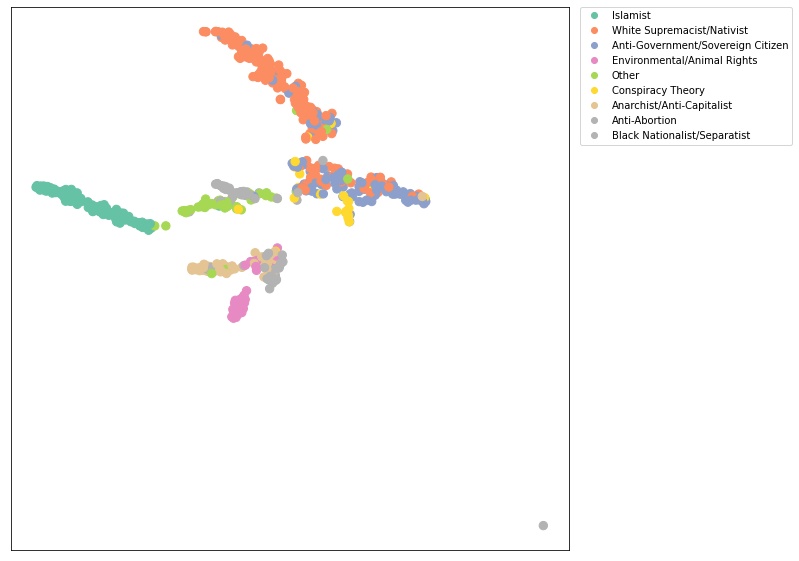

*********************Running model is G2R(
  (conv1): GCNConv(90, 1024)
  (convs): ModuleList(
    (0-1): 2 x GCNConv(1024, 1024)
  )
  (fc): Linear(in_features=1024, out_features=9, bias=True)
  (dropout): Dropout(p=0.5, inplace=False)
)************************
Epoch 0: Train Loss: 2.1927, Test Loss: 1.8757, Test Accuracy: 0.3838
Epoch 50: Train Loss: 0.0797, Test Loss: 0.7989, Test Accuracy: 0.7894
Epoch 100: Train Loss: 0.0032, Test Loss: 1.4254, Test Accuracy: 0.8034
Epoch 150: Train Loss: 0.0007, Test Loss: 1.5696, Test Accuracy: 0.7972
Epoch 200: Train Loss: 0.0009, Test Loss: 1.6340, Test Accuracy: 0.7972
Epoch 250: Train Loss: 0.0002, Test Loss: 1.6658, Test Accuracy: 0.7988
Epoch 300: Train Loss: 0.0002, Test Loss: 1.7610, Test Accuracy: 0.7956
Epoch 350: Train Loss: 0.0002, Test Loss: 1.8208, Test Accuracy: 0.7941
Epoch 400: Train Loss: 0.0001, Test Loss: 1.8575, Test Accuracy: 0.7988
Epoch 450: Train Loss: 0.0013, Test Loss: 1.7382, Test Accuracy: 0.8050
Epoch 500: Train Los

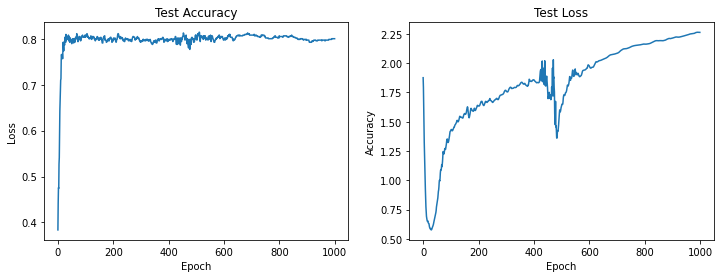

Accuracy: 0.8003
Confusion Matrix:
Classification Report:
                                   precision    recall  f1-score   support

                         Islamist       0.99      0.99      0.99       104
       White Supremacist/Nativist       0.79      0.88      0.83       196
Anti-Government/Sovereign Citizen       0.67      0.57      0.62       110
      Environmental/Animal Rights       0.91      0.95      0.93        42
                            Other       0.77      0.73      0.75        49
                Conspiracy Theory       0.61      0.52      0.56        27
        Anarchist/Anti-Capitalist       0.78      0.75      0.76        52
                    Anti-Abortion       0.79      0.72      0.75        32
     Black Nationalist/Separatist       0.73      0.76      0.75        29

                         accuracy                           0.80       641
                        macro avg       0.78      0.76      0.77       641
                     weighted avg       

C:\Users\Razaq\AppData\Local\Programs\Python\Python310\lib\site-packages\sklearn\manifold\_t_sne.py:795: FutureWarning: The default initialization in TSNE will change from 'random' to 'pca' in 1.2.
  warnings.warn(
C:\Users\Razaq\AppData\Local\Programs\Python\Python310\lib\site-packages\sklearn\manifold\_t_sne.py:805: FutureWarning: The default learning rate in TSNE will change from 200.0 to 'auto' in 1.2.
  warnings.warn(


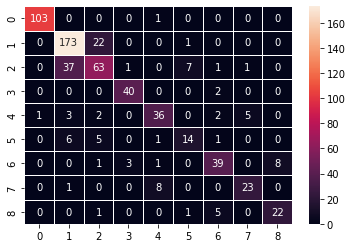

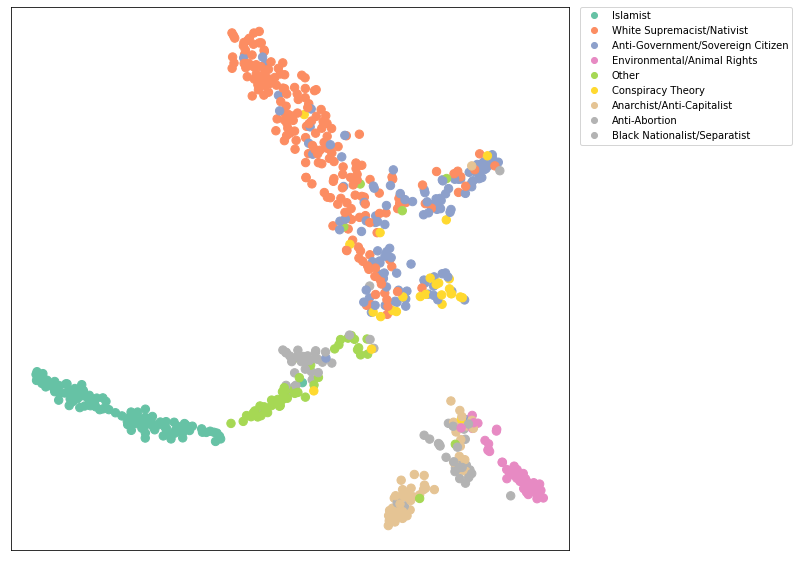

*********************Running model is FisherGCN(
  (conv1): GCNConv(90, 1024)
  (convs): ModuleList(
    (0-1): 2 x GCNConv(1024, 1024)
  )
  (fc): Linear(in_features=1024, out_features=9, bias=True)
  (dropout): Dropout(p=0.5, inplace=False)
)************************
Epoch 0: Train Loss: 2.1881, Test Loss: 1.8703, Test Accuracy: 0.3385
Epoch 50: Train Loss: 0.0738, Test Loss: 0.8273, Test Accuracy: 0.7972
Epoch 100: Train Loss: 0.0022, Test Loss: 1.4046, Test Accuracy: 0.8144
Epoch 150: Train Loss: 0.0007, Test Loss: 1.5636, Test Accuracy: 0.8034
Epoch 200: Train Loss: 0.0006, Test Loss: 1.6634, Test Accuracy: 0.7988
Epoch 250: Train Loss: 0.0004, Test Loss: 1.6663, Test Accuracy: 0.7972
Epoch 300: Train Loss: 0.0003, Test Loss: 1.7719, Test Accuracy: 0.7988
Epoch 350: Train Loss: 0.0002, Test Loss: 1.7977, Test Accuracy: 0.8034
Epoch 400: Train Loss: 0.0001, Test Loss: 1.8572, Test Accuracy: 0.7941
Epoch 450: Train Loss: 0.0001, Test Loss: 1.8863, Test Accuracy: 0.7988
Epoch 500: Tra

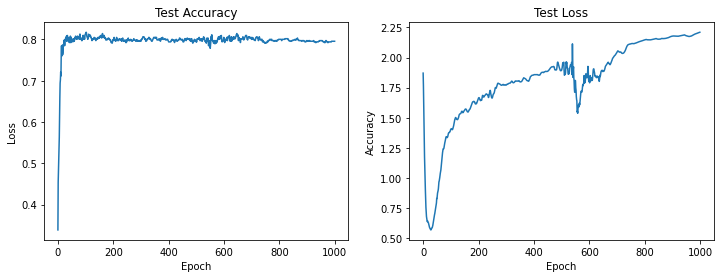

Accuracy: 0.7956
Confusion Matrix:
Classification Report:
                                   precision    recall  f1-score   support

                         Islamist       1.00      0.99      1.00       104
       White Supremacist/Nativist       0.79      0.87      0.83       196
Anti-Government/Sovereign Citizen       0.65      0.60      0.63       110
      Environmental/Animal Rights       0.97      0.93      0.95        42
                            Other       0.76      0.78      0.77        49
                Conspiracy Theory       0.55      0.41      0.47        27
        Anarchist/Anti-Capitalist       0.75      0.77      0.76        52
                    Anti-Abortion       0.76      0.69      0.72        32
     Black Nationalist/Separatist       0.68      0.72      0.70        29

                         accuracy                           0.80       641
                        macro avg       0.77      0.75      0.76       641
                     weighted avg       

C:\Users\Razaq\AppData\Local\Programs\Python\Python310\lib\site-packages\sklearn\manifold\_t_sne.py:795: FutureWarning: The default initialization in TSNE will change from 'random' to 'pca' in 1.2.
  warnings.warn(
C:\Users\Razaq\AppData\Local\Programs\Python\Python310\lib\site-packages\sklearn\manifold\_t_sne.py:805: FutureWarning: The default learning rate in TSNE will change from 200.0 to 'auto' in 1.2.
  warnings.warn(


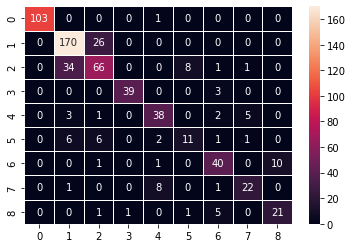

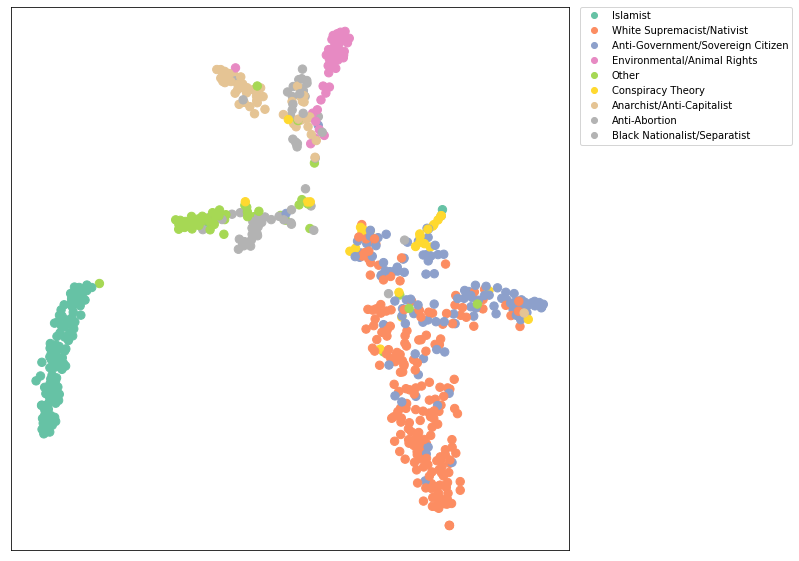

*********************Running model is GraphSAGE(
  (conv1): SAGEConv(90, 1024, aggr=mean)
  (convs): ModuleList(
    (0-1): 2 x SAGEConv(1024, 1024, aggr=mean)
  )
  (fc): Linear(in_features=1024, out_features=9, bias=True)
)************************
Epoch 0: Train Loss: 2.2159, Test Loss: 1.9575, Test Accuracy: 0.3058
Epoch 50: Train Loss: 0.8419, Test Loss: 0.6177, Test Accuracy: 0.7660
Epoch 100: Train Loss: 0.7413, Test Loss: 0.5570, Test Accuracy: 0.7972
Epoch 150: Train Loss: 0.7009, Test Loss: 0.5390, Test Accuracy: 0.8144
Epoch 200: Train Loss: 0.6437, Test Loss: 0.5255, Test Accuracy: 0.8112
Epoch 250: Train Loss: 0.6195, Test Loss: 0.5283, Test Accuracy: 0.8050
Epoch 300: Train Loss: 0.6058, Test Loss: 0.5233, Test Accuracy: 0.8144
Epoch 350: Train Loss: 0.5722, Test Loss: 0.5336, Test Accuracy: 0.8097
Epoch 400: Train Loss: 0.5708, Test Loss: 0.5471, Test Accuracy: 0.7988
Epoch 450: Train Loss: 0.5158, Test Loss: 0.5470, Test Accuracy: 0.8081
Epoch 500: Train Loss: 0.4843, Te

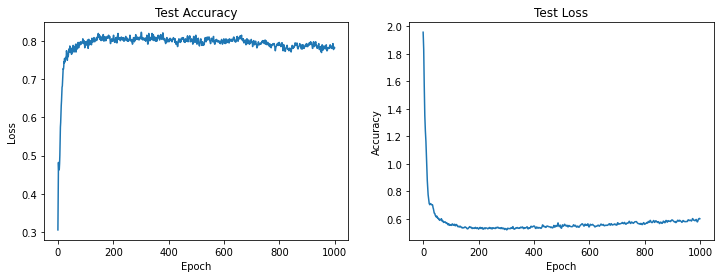

Accuracy: 0.7816
Confusion Matrix:
Classification Report:
                                   precision    recall  f1-score   support

                         Islamist       0.98      0.99      0.99       104
       White Supremacist/Nativist       0.77      0.90      0.83       196
Anti-Government/Sovereign Citizen       0.77      0.46      0.58       110
      Environmental/Animal Rights       0.93      0.88      0.90        42
                            Other       0.68      0.65      0.67        49
                Conspiracy Theory       0.47      0.70      0.57        27
        Anarchist/Anti-Capitalist       0.79      0.79      0.79        52
                    Anti-Abortion       0.61      0.59      0.60        32
     Black Nationalist/Separatist       0.77      0.79      0.78        29

                         accuracy                           0.78       641
                        macro avg       0.75      0.75      0.74       641
                     weighted avg       

C:\Users\Razaq\AppData\Local\Programs\Python\Python310\lib\site-packages\sklearn\manifold\_t_sne.py:795: FutureWarning: The default initialization in TSNE will change from 'random' to 'pca' in 1.2.
  warnings.warn(
C:\Users\Razaq\AppData\Local\Programs\Python\Python310\lib\site-packages\sklearn\manifold\_t_sne.py:805: FutureWarning: The default learning rate in TSNE will change from 200.0 to 'auto' in 1.2.
  warnings.warn(


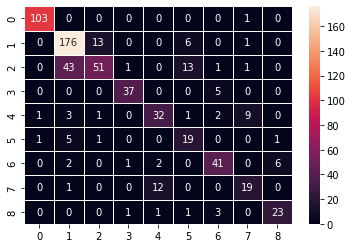

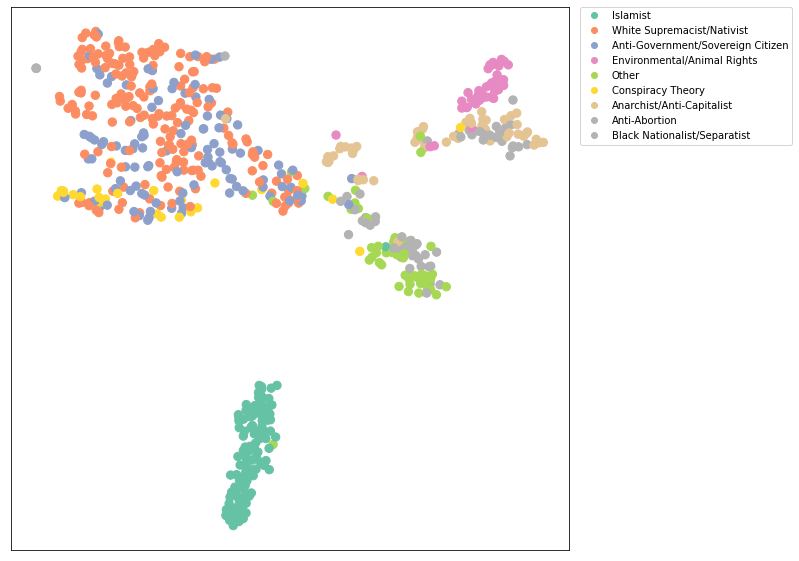

*********************Running model is GAT(
  (conv1): GATConv(90, 1024, heads=8)
  (convs): ModuleList(
    (0-1): 2 x GATConv(8192, 1024, heads=8)
  )
  (fc): Linear(in_features=8192, out_features=9, bias=True)
)************************
Epoch 0: Train Loss: 2.2647, Test Loss: 1.2655, Test Accuracy: 0.6162
Epoch 50: Train Loss: 0.9540, Test Loss: 0.5997, Test Accuracy: 0.7769
Epoch 100: Train Loss: 0.8416, Test Loss: 0.6507, Test Accuracy: 0.7988
Epoch 150: Train Loss: 0.7793, Test Loss: 0.7265, Test Accuracy: 0.7878
Epoch 200: Train Loss: 0.7433, Test Loss: 0.8078, Test Accuracy: 0.8034
Epoch 250: Train Loss: 0.7806, Test Loss: 0.9270, Test Accuracy: 0.7863
Epoch 300: Train Loss: 0.6823, Test Loss: 1.0043, Test Accuracy: 0.8003
Epoch 350: Train Loss: 0.6721, Test Loss: 1.0066, Test Accuracy: 0.7878
Epoch 400: Train Loss: 0.6857, Test Loss: 1.0105, Test Accuracy: 0.8222
Epoch 450: Train Loss: 0.6566, Test Loss: 1.1821, Test Accuracy: 0.7956
Epoch 500: Train Loss: 0.6756, Test Loss: 1.2

In [ ]:
train_losses = []
test_losses = []
test_accs = []

models = [GCN(), G2R(), FisherGCN(), GraphSAGE(), GAT()]  
#models = [GCN(), G2R(), FisherGCN(), GraphSAGE()] 

for model in models:
    train_losses = []
    test_losses = []
    test_accs = []

    print(f'*********************Running model is {model}************************')

    optimizer = torch.optim.Adam(model.parameters(), lr=0.001) 
    criterion = torch.nn.CrossEntropyLoss()

    for epoch in range(num_epochs):
        model.train()
        optimizer.zero_grad()
        output = model(x_train, edge_index_train)
        train_loss = criterion(output, y_train.long())
        train_loss.backward()
        optimizer.step()
        train_losses.append(train_loss.item())

        model.eval()
        with torch.no_grad():
            output = model(x_test, edge_index_test)
            test_loss = criterion(output, y_test.long())
            test_losses.append(test_loss.item())
            predictions = output.argmax(dim=1)
            test_acc = (predictions == y_test.long()).sum().item() / len(y_test)
            test_accs.append(test_acc)

        if epoch % 50 == 0:
            print(f"Epoch {epoch}: Train Loss: {train_loss.item():.4f}, Test Loss: {test_loss.item():.4f}, Test Accuracy: {test_acc:.4f}")

    # Plot the loss and accuracy graphs
    fig, ax = plt.subplots(1, 2, figsize=(12, 4))
    ax[0].plot(test_accs)
    ax[0].set_xlabel("Epoch")
    ax[0].set_ylabel("Loss")
    ax[0].set_title("Test Accuracy")
    ax[1].plot(test_losses)
    ax[1].set_xlabel("Epoch")
    ax[1].set_ylabel("Accuracy")
    ax[1].set_title("Test Loss")
    plt.show()

    model.eval()
    with torch.no_grad():
      output = model(x_test, edge_index_test)
      predictions = output.argmax(dim=1)
      accuracy = (predictions == y_test.long()).sum().item() / len(y_test)
      print(f"Accuracy: {accuracy:.4f}")
      print("Confusion Matrix:")
      cm = confusion_matrix(y_test, predictions)
      #print(cm)
      sns.heatmap(cm, linewidths=1, annot=True, fmt='g')
      print("Classification Report:")
      print(classification_report(y_test, predictions, target_names=label_list))
      visualize(output, y_test, label_list)
